## Training fully-convolutional network with synthetic data

In [1]:
import numpy as np
import os
import torch
import time
from torch import nn
from torch.nn import functional
from torch.utils.data import Dataset, DataLoader
import random

import matplotlib.pyplot as plt
from matplotlib import cm as cmap
from matplotlib import colors
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D
from mpl_toolkits import mplot3d

#import uxo_utils

from uxo_cnn_classification import (
    train_net, SurveyParameters, 
    normalize_data, data3dorder,
    accuracy, get_mislabeled,
    confusion_matrix, load_sensor_info
)

In [2]:
# initialization random seed for training and number of epochs:
seeds = [4750, 5293, 9254]
rseed = seeds[0]
nepochs = 20

In [3]:
# sequim group 2021
class_dict = {
    0: "not TOI",
    1: "155mm group",
    2: "105mm group",
    3: "81mm group",
    4: "60mm M49",
    5: "40mm L70",
    6: "clutter0",
    7: "clutter1",
    8: "clutter2"
}
survpars = SurveyParameters(
    sensor_type = 'ultratema',
    ymax = 4.5,
    y_spacing = 0.3,
    min_standoff = 0.5,
    #noise_file = ''
)
train_case = 'sequimgroup2021'

In [4]:
sensorinfo = load_sensor_info(survpars.sensor_type)
n_class = len(class_dict.keys())
#ntx = len(sensorinfo.transmitters)
#nrx = len(sensorinfo.receivers)//3 # number of receiver cubes
ntx = sensorinfo.ntx
nrx = sensorinfo.nrx
dy = survpars.y_spacing / ntx
nloc = int(survpars.ymax/dy)
ncycles = int(nloc/ntx)

times = np.load(os.path.sep.join([f'/home/jorge/git/uxo-btg-synthetic/data_{train_case}', "times.npy"]))

### Load synthetic data, labels and label masks:

In [5]:
class UXOResponseDataset(Dataset):
    def __init__(self, labels_file, labmasks_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels = np.load(labels_file)
        self.labmasks = np.load(labmasks_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        data = np.load(os.path.join(self.root_dir, f'data{idx}.npy'))
        label = self.labels[idx]
        labmask = self.labmasks[idx]
        sample = {'data': data, 'label': label, 'labmask': labmask}
        
        if self.transform:
            sample = self.transform(sample)

        return sample
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        data, labels, labmasks = sample['data'], sample['label'], sample['labmask']
        return {'data': torch.from_numpy(np.float32(data)),
                #'labels': torch.Tensor(labels),
                'labmask': torch.from_numpy(np.float32(labmasks))}
        

In [6]:
uxoresponse_train = UXOResponseDataset(labels_file=f'/home/jorge/git/uxo-btg-synthetic/data_{train_case}/labels.npy',
                                         labmasks_file=f'/home/jorge/git/uxo-btg-synthetic/data_{train_case}/labmasks.npy',
                                         root_dir=f'/home/jorge/git/uxo-btg-synthetic/data_{train_case}',
                                         transform=ToTensor())

In [7]:
uxoresponse_test = UXOResponseDataset(labels_file=f'/home/jorge/git/uxo-btg-synthetic/datatest_{train_case}/labels.npy',
                                         labmasks_file=f'/home/jorge/git/uxo-btg-synthetic/datatest_{train_case}/labmasks.npy',
                                         root_dir=f'/home/jorge/git/uxo-btg-synthetic/datatest_{train_case}',
                                         transform=ToTensor())

In [8]:
dataloader_train = DataLoader(uxoresponse_train, batch_size=32, shuffle=True, num_workers=0)
dataloader_test = DataLoader(uxoresponse_test, batch_size=100, shuffle=True, num_workers=0)

## Plot some label masks samples:

In [9]:
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
if len(class_dict) > 10:
    tab10_list = [mpl.cm.tab10.colors[i] for i in range(10)]
    added_colors = [mpl.colors.to_rgb(c) for c in ["#ebb50a","lightgreen"]][:len(class_dict)-10] # added color to standard tab10
    my_cmap = ListedColormap(tab10_list + added_colors, name="my_cmap")
else:
    my_cmap = ListedColormap([mpl.cm.tab10.colors[i] for i in range(len(class_dict))], name="my_cmap")

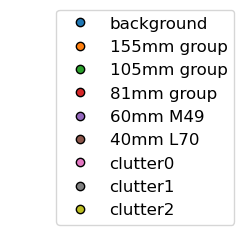

In [10]:
# show labels and colors:
fig, ax = plt.subplots(figsize=(3, n_class*0.2))

marker_size=6
mew = 1.0
custom_lines = [Line2D([0], [0], c="w", marker='o', ms=marker_size, mfc=my_cmap.colors[i], mec="k", lw=1.0, mew=mew) for i in range(len(class_dict))]

ax.axis('off')
ax.legend(custom_lines, ['background'] + list(class_dict.values())[1:], loc="lower right", fontsize=12)

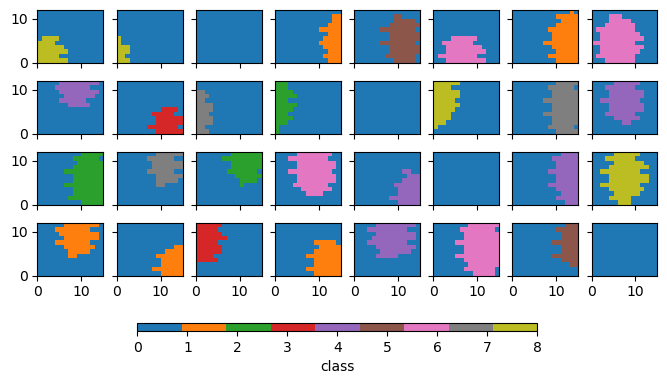

In [11]:
# get masks for random samples
fig, ax = plt.subplots(4,8,figsize=(1.0*8,1.0*4))
labmask_batch = next(iter(dataloader_train))['labmask']

ax = ax.ravel()
for i,lm in enumerate(labmask_batch):
    out = ax[i].pcolormesh(lm,vmin=0,vmax=n_class-1, cmap=my_cmap)
    if i%8 != 0:
        ax[i].set_yticklabels([])
    if i < 24:
        ax[i].set_xticklabels([])

plt.setp(ax,aspect=1)

fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.25, 0.07, 0.5, 0.02])
cb = plt.colorbar(out, cbar_ax, orientation="horizontal")
cb.set_label('class')

### Train neural net:

In [12]:
cnn_pars_dir = os.path.join(os.getcwd(), 'cnn_parameters')

if not os.path.exists(cnn_pars_dir):
    os.mkdir(cnn_pars_dir)

In [13]:
logfile = os.path.join(cnn_pars_dir, f'trainlog_{train_case}_{rseed}')
net = train_net(survpars, class_dict, dataloader_train, dataloader_test, times, rseed, nepochs, logfile)

gpu detected, training will use it.
Total number of parameters 784531
Total number of training data 110000
Initial loss =  2.042385
Check:log(9) =  2.1972245773362196

Initial accuracy: 0.10894444444444444
Check random    : 0.1111111111111111
epoch:   0, loss: 6.917e-01, accuracy: 0.782
epoch:   1, loss: 6.005e-01, accuracy: 0.834
epoch:   2, loss: 5.784e-01, accuracy: 0.808
epoch:   3, loss: 5.662e-01, accuracy: 0.906
epoch:   4, loss: 5.578e-01, accuracy: 0.799
epoch:   5, loss: 5.510e-01, accuracy: 0.931
epoch:   6, loss: 5.471e-01, accuracy: 0.929
epoch:   7, loss: 5.435e-01, accuracy: 0.871
epoch:   8, loss: 5.400e-01, accuracy: 0.928
epoch:   9, loss: 5.369e-01, accuracy: 0.892
epoch:  10, loss: 5.352e-01, accuracy: 0.861
epoch:  11, loss: 5.327e-01, accuracy: 0.867
epoch:  12, loss: 5.314e-01, accuracy: 0.940
epoch:  13, loss: 5.294e-01, accuracy: 0.922
epoch:  14, loss: 5.278e-01, accuracy: 0.917
epoch:  15, loss: 5.269e-01, accuracy: 0.794
epoch:  16, loss: 5.259e-01, accuracy

In [14]:
# save trained parameters:
torch.save(net.state_dict(), os.path.join(cnn_pars_dir, f'net{train_case}_{rseed}.pth'))

In [15]:
# send cnn to cpu for evaluation:
if torch.device != 'cpu':
    net.cpu()

In [16]:
net.eval()

ConvNet(
  (K3d): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 16x12x3x3x3]
      (1): Parameter containing: [torch.FloatTensor of size 16x16x3x3x3]
      (2): Parameter containing: [torch.FloatTensor of size 16x16x3x3x3]
      (3): Parameter containing: [torch.FloatTensor of size 16x16x3x3x3]
  )
  (bnorms3d): ModuleList(
    (0): BatchNorm3d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (K2d): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 128x400x3x3]
      (1): Parameter containing: [torch.FloatTensor of size 128x128x3x3]
      (2): Parameter conta

In [17]:
dtrain, labmask_train = next(iter(dataloader_train)).values()
dtest, labmask_test = next(iter(dataloader_test)).values()

In [18]:
dtest.shape

torch.Size([100, 12, 12, 15, 25])

In [20]:
# training set

x_train_net, probs_train = net(dtrain)
_, pred_train = torch.max(probs_train, dim=1)

# test set
x_test_net, probs_test = net(dtest)
_, pred_test = torch.max(probs_test, dim=1)

print(f"training accuracy: {accuracy(probs_train, labmask_train):1.4f}")
print(f"test accuracy    : {accuracy(probs_test, labmask_test):1.4f}")

#cc = probs_to_classes(probs_train)

training accuracy: 0.9368
test accuracy    : 0.9295


### Plot predicted vs true

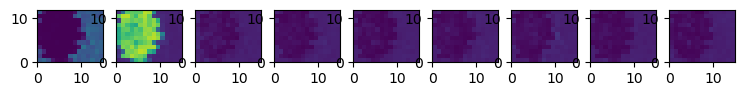

In [22]:
indt = 5
fig,ax = plt.subplots(1,n_class,figsize=(1.0*n_class,2.0))

for i in range(n_class):
    ax[i].pcolormesh(probs_test[indt,i,:,:].detach(),vmin=0,vmax=1,cmap='viridis')
    ax[i].set_aspect(1)

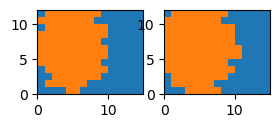

In [23]:
fig,ax = plt.subplots(1,2,figsize=(1.5*2,2.0))

ax[0].pcolormesh(labmask_test[indt,:,:],vmin=0,vmax=n_class-1,cmap=my_cmap)
ax[0].set_aspect(1)
ax[1].pcolormesh(pred_test[indt,:,:],vmin=0,vmax=n_class-1,cmap=my_cmap)
ax[1].set_aspect(1)